# Assignment 2 - Feature extraction and classification

Note: This notebook file for the assignment has deviations from the course guide with respect to the structure, sentence framing, question framing and numbering. Please consider this notebook file structure as the final structure and follow this.

In this assignment, you are expected to

(1) extract global features from CIFAR10 dataset with one of the pre-trained neural networks available in pytorch,

(2) classify the dataset using the traditional k-Nearest Neighbours classifier,

and

(3) implement k-fold cross-validation to evaluate your model.

------------------------

In [1]:
import dill as dill
# Load all the needed packages for this assignment here
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

/Users/hungnguyen/miniforge3/envs/DS-CVassignment/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/hungnguyen/miniforge3/envs/DS-CVassignment/lib/python3.10/site-packages/torchvision/image.so, 0x0006): symbol not found in flat namespace '__ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefINS2_6SymIntEEENS2_8optionalINS2_10ScalarTypeEEENS6_INS2_6LayoutEEENS6_INS2_6DeviceEEENS6_IbEENS6_INS2_12MemoryFormatEEE'
  warn(f"Failed to load image Python extension: {e}")


When working with Pytorch, dataloader() is a must to know function. Read more about this function and the parameters it accepts in https://blog.paperspace.com/dataloaders-abstractions-pytorch/

In [2]:
from torch.utils.data import DataLoader

The variable 'transform' encapsulates the needed transformations of our data. Read more about transforms in https://blog.paperspace.com/dataloaders-abstractions-pytorch/

In [3]:
transform = transforms.Compose([
    # resize
    transforms.Resize(32),
    # center-crop
    transforms.CenterCrop(32),
    # to-tensor
    transforms.ToTensor(),
    # normalize
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),

])

### INPUT DATASET

Load the CIFAR10 dataset from Pytorch

In [4]:
dataset = torchvision.datasets.CIFAR10(root='cifar10', train=True, download=False, transform=transform)
train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=4, shuffle=False)
dataset_test = torchvision.datasets.CIFAR10(root='cifar10', train=False, download=False, transform=transform)

#### Exercise 2.1 - Dataset preparation

**a)** Write a function **'train_test_split(dataset, ratio)'** which takes a dataset array as an input and returns two dataset arrays- one for training and another for testing.
# I will use the sklearn train_test_split instead.



### FEATURE EXTRACTION

Extract descriptors from the images in your train and test dataset. The dataset split should remain the same for all the experiments if you want to be fair when comparing performance.

#### Exercise 2.2 - Feature 1 - RGB descriptor

Implement the same code you wrote for extracting the overall RGB descriptors(of size n x 24) as in assignment 1 here.

In [5]:
# Ex.2.2 your code here

def extract_rgb_descriptors(datasets):
    dataset_list = []
    dataset_label = []
    for image, label in datasets:
        image_feature = []
        # image_feature_with_label = []
        colors = ("red", "green", "blue")
        image = np.array(image)
        # print(image.shape)
        # plt.imshow(image)
        # break
        # image_feature_with_label.append(label)
        for channel_id, color in enumerate(colors):
            histogram, bin_edges = np.histogram(
                image[:, :, channel_id], bins=8, range=(0, 256)
            )
            image_feature = np.concatenate((image_feature, histogram))
        # print(image_feature)
        image_feature = image_feature / 784
        # image_feature = np.append(image_feature,label)
        dataset_label.append(label)
        dataset_list.append(image_feature)
    return dataset_list, dataset_label

rgb_descriptors, rgb_descriptors_label = extract_rgb_descriptors(dataset)

#### Exercise 2.3 - Feature 2 - Extract CNN descriptors using pre-traind networks

Load one of the pretrained network (resnet, alexnet, vgg, squeezenet, densenet, inception) from pytorch to extract global features from the images present in the dataset. 
We will use the output values from the layer present just before the fully connected layer of the deep network as a descriptor, i.e. we will remove the last fully-connected layer. Therefore, after feed-forwarding the input image through the network, we save the output as the descriptor of the image. We do this for all the images present in the dataset to get the overall CNN descriptors.

You may refer to this link for debugging purposes - https://stackoverflow.com/questions/52548174/how-to-remove-the-last-fc-layer-from-a-resnet-model-in-pytorch

In [6]:
from torchvision.models import ResNet18_Weights, resnet18

# Ex.2.3 your code here
# name of the model you wish to use - it should be selected from this list
# [resnet]
from pytorch_resnet_cifar10.resnet import resnet32
import dill  # in order to save Lambda Layer

resnet_model = resnet32()
resnet_pretrained_state_dict = torch.load("pytorch_resnet_cifar10/pretrained_models/resnet32-d509ac18.th", map_location=torch.device('cpu'))
resnet_model = torch.nn.DataParallel(resnet_model)

resnet_model.load_state_dict(resnet_pretrained_state_dict['state_dict'])
torch.save(resnet_model.module, 'resnet20_check_point.pth', pickle_module=dill)

# load the converted pretrained model
resnet_model = torch.load('resnet20_check_point.pth')

new_resnet_model = torch.nn.Sequential(*(list(resnet_model.children())[:-1]))




In [7]:
cnn_descriptors = []
cnn_descriptors_label = []
for i, data in enumerate(train_dataloader):
    loader_outputs = new_resnet_model(data[0]).detach().numpy()
    for j in range(len(loader_outputs)):
        cnn_descriptors.append(loader_outputs[j].flatten())
        cnn_descriptors_label.append(int(data[1][j]))



### PERFORMANCE EVALUATION

#### Exercise 2.4 - Error function

Implement a function to evaluate the accuracy of your prediction. We will rely on the evaluation metric 'accuracy'.

You are suggested to also use f-score, recall and precision. Have a look at https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html 

In [8]:
from sklearn.metrics import precision_recall_fscore_support

def accuracy_metric(actual, predicted):
    # Ex.2.4 your code here
    return precision_recall_fscore_support(y_true=actual, y_pred=predicted, average="micro", labels=np.linspace(1,10,10))
# print(accuracy_metric(actual=np.array([2, 9, 1, 3, 5, 4, 6, 7, 8, 10 ]), predicted=np.array([1, 9, 2, 4, 3, 5, 6, 7, 8, 10 ])))


In [9]:
print(cnn_descriptors[0].shape)

(4096,)


### TRAIN AND TEST YOUR MODEL

#### Exercise 2.5 - k Nearest Neighbour model

For this exercise, first split the extracted overall RGB and CNN descriptor to train and test sets with the help of the 'train_test_split()' function that you implemented before.

**a)** Apply the classifier with different values of k (number of nearest neighbours) to the train **RGB descriptor** set and evaluate the performance of your models using the accuracy_metric() function that you implemented before.

You can have a look at the documentation to understand the parameters that define the learning of the model,
https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier

**b)** Apply the classifier with different values of k (number of nearest neighbours) to the train **CNN descriptor** and evaluate the performance of your models using the accuracy_metric() function that you implemented before.


In [10]:
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
from sklearn.model_selection import train_test_split

cnn_descriptors_train, cnn_descriptors_test, cnn_descriptors_train_label, cnn_descriptors_test_label = train_test_split(cnn_descriptors, cnn_descriptors_label, test_size=0.2, random_state=42)
rgb_descriptors_train, rgb_descriptors_test, rgb_descriptors_train_label, rgb_descriptors_test_label = train_test_split(rgb_descriptors, rgb_descriptors_label, test_size=0.2, random_state=41)

# Use your k-NN - play with the value of the parameters to see how the model performs
k_value_list = [2,4,6,10,15]


for k in k_value_list:
    cnn_k_neighbors = KNeighborsClassifier(n_neighbors=k)
    rgb_k_neighbor = KNeighborsClassifier(n_neighbors=k)

    cnn_k_neighbors.fit(cnn_descriptors_train, cnn_descriptors_train_label)
    rgb_k_neighbor.fit(rgb_descriptors_train, rgb_descriptors_train_label)
    print("k value = ", k)
    print("Default KNC score for RGB descriptors: ", rgb_k_neighbor.score(rgb_descriptors_test, rgb_descriptors_test_label))
    print("Default KNC score for CNN descriptors: ", cnn_k_neighbors.score(cnn_descriptors_test, cnn_descriptors_test_label))
    print("Accuracy metrics for RGB descriptors: ", accuracy_metric(rgb_descriptors_test_label, rgb_k_neighbor.predict(rgb_descriptors_test)))
    print("Accuracy metrics for CNN descriptors: ",accuracy_metric(cnn_descriptors_test_label, cnn_k_neighbors.predict(cnn_descriptors_test)))
    print("------------------------")

k value =  2
Default KNC score for RGB descriptors:  0.1168
Default KNC score for CNN descriptors:  0.8103
Accuracy metrics for RGB descriptors:  (0.10997137404580153, 0.10234210234210234, 0.10601966308284942, None)
Accuracy metrics for CNN descriptors:  (0.8197017623136015, 0.8038107898526642, 0.8116785055092567, None)
------------------------
k value =  4
Default KNC score for RGB descriptors:  0.1241
Default KNC score for CNN descriptors:  0.8464
Accuracy metrics for RGB descriptors:  (0.11911987860394538, 0.10456210456210456, 0.11136726369923747, None)
Accuracy metrics for CNN descriptors:  (0.8530530082755535, 0.8450204940733356, 0.8490177527964827, None)
------------------------
k value =  6
Default KNC score for RGB descriptors:  0.1367
Default KNC score for CNN descriptors:  0.8503
Accuracy metrics for RGB descriptors:  (0.1349611273080661, 0.12332112332112333, 0.12887883533437738, None)
Accuracy metrics for CNN descriptors:  (0.8535230051122472, 0.8507809903622466, 0.852149791

#### Exercise 2.6 - Visualize results 

**a)** Since you already applied PCA to the extracted overall RGB descriptor in assignment 1, now apply PCA to the extracted overall **CNN descriptor**.

Steps to follow:

1) Choose the kNN classifier with k value that gave you the best results in the previous exercise and use it to make predictions on your train CNN descriptor set.

2) Apply PCA on the train set and select the first 2 principal components to represent each sample.

3) Plot the principal components representing the samples with empty circles. Use one color per ground truth class labels. On top of this, plot the samples again but now with filled circles. For these filled circles, use the color of the class predicted per sample in step 1. You can note that wrong classifications will make the colours not coincide.

In [11]:
# Ex.2.6a your code here
from sklearn.decomposition import PCA
cnn_descriptors_prediction = cnn_k_neighbors.predict(cnn_descriptors_train)
pca = PCA(n_components=2)
features_pca_cnn = pca.fit_transform(cnn_descriptors_train, cnn_descriptors_train_label)

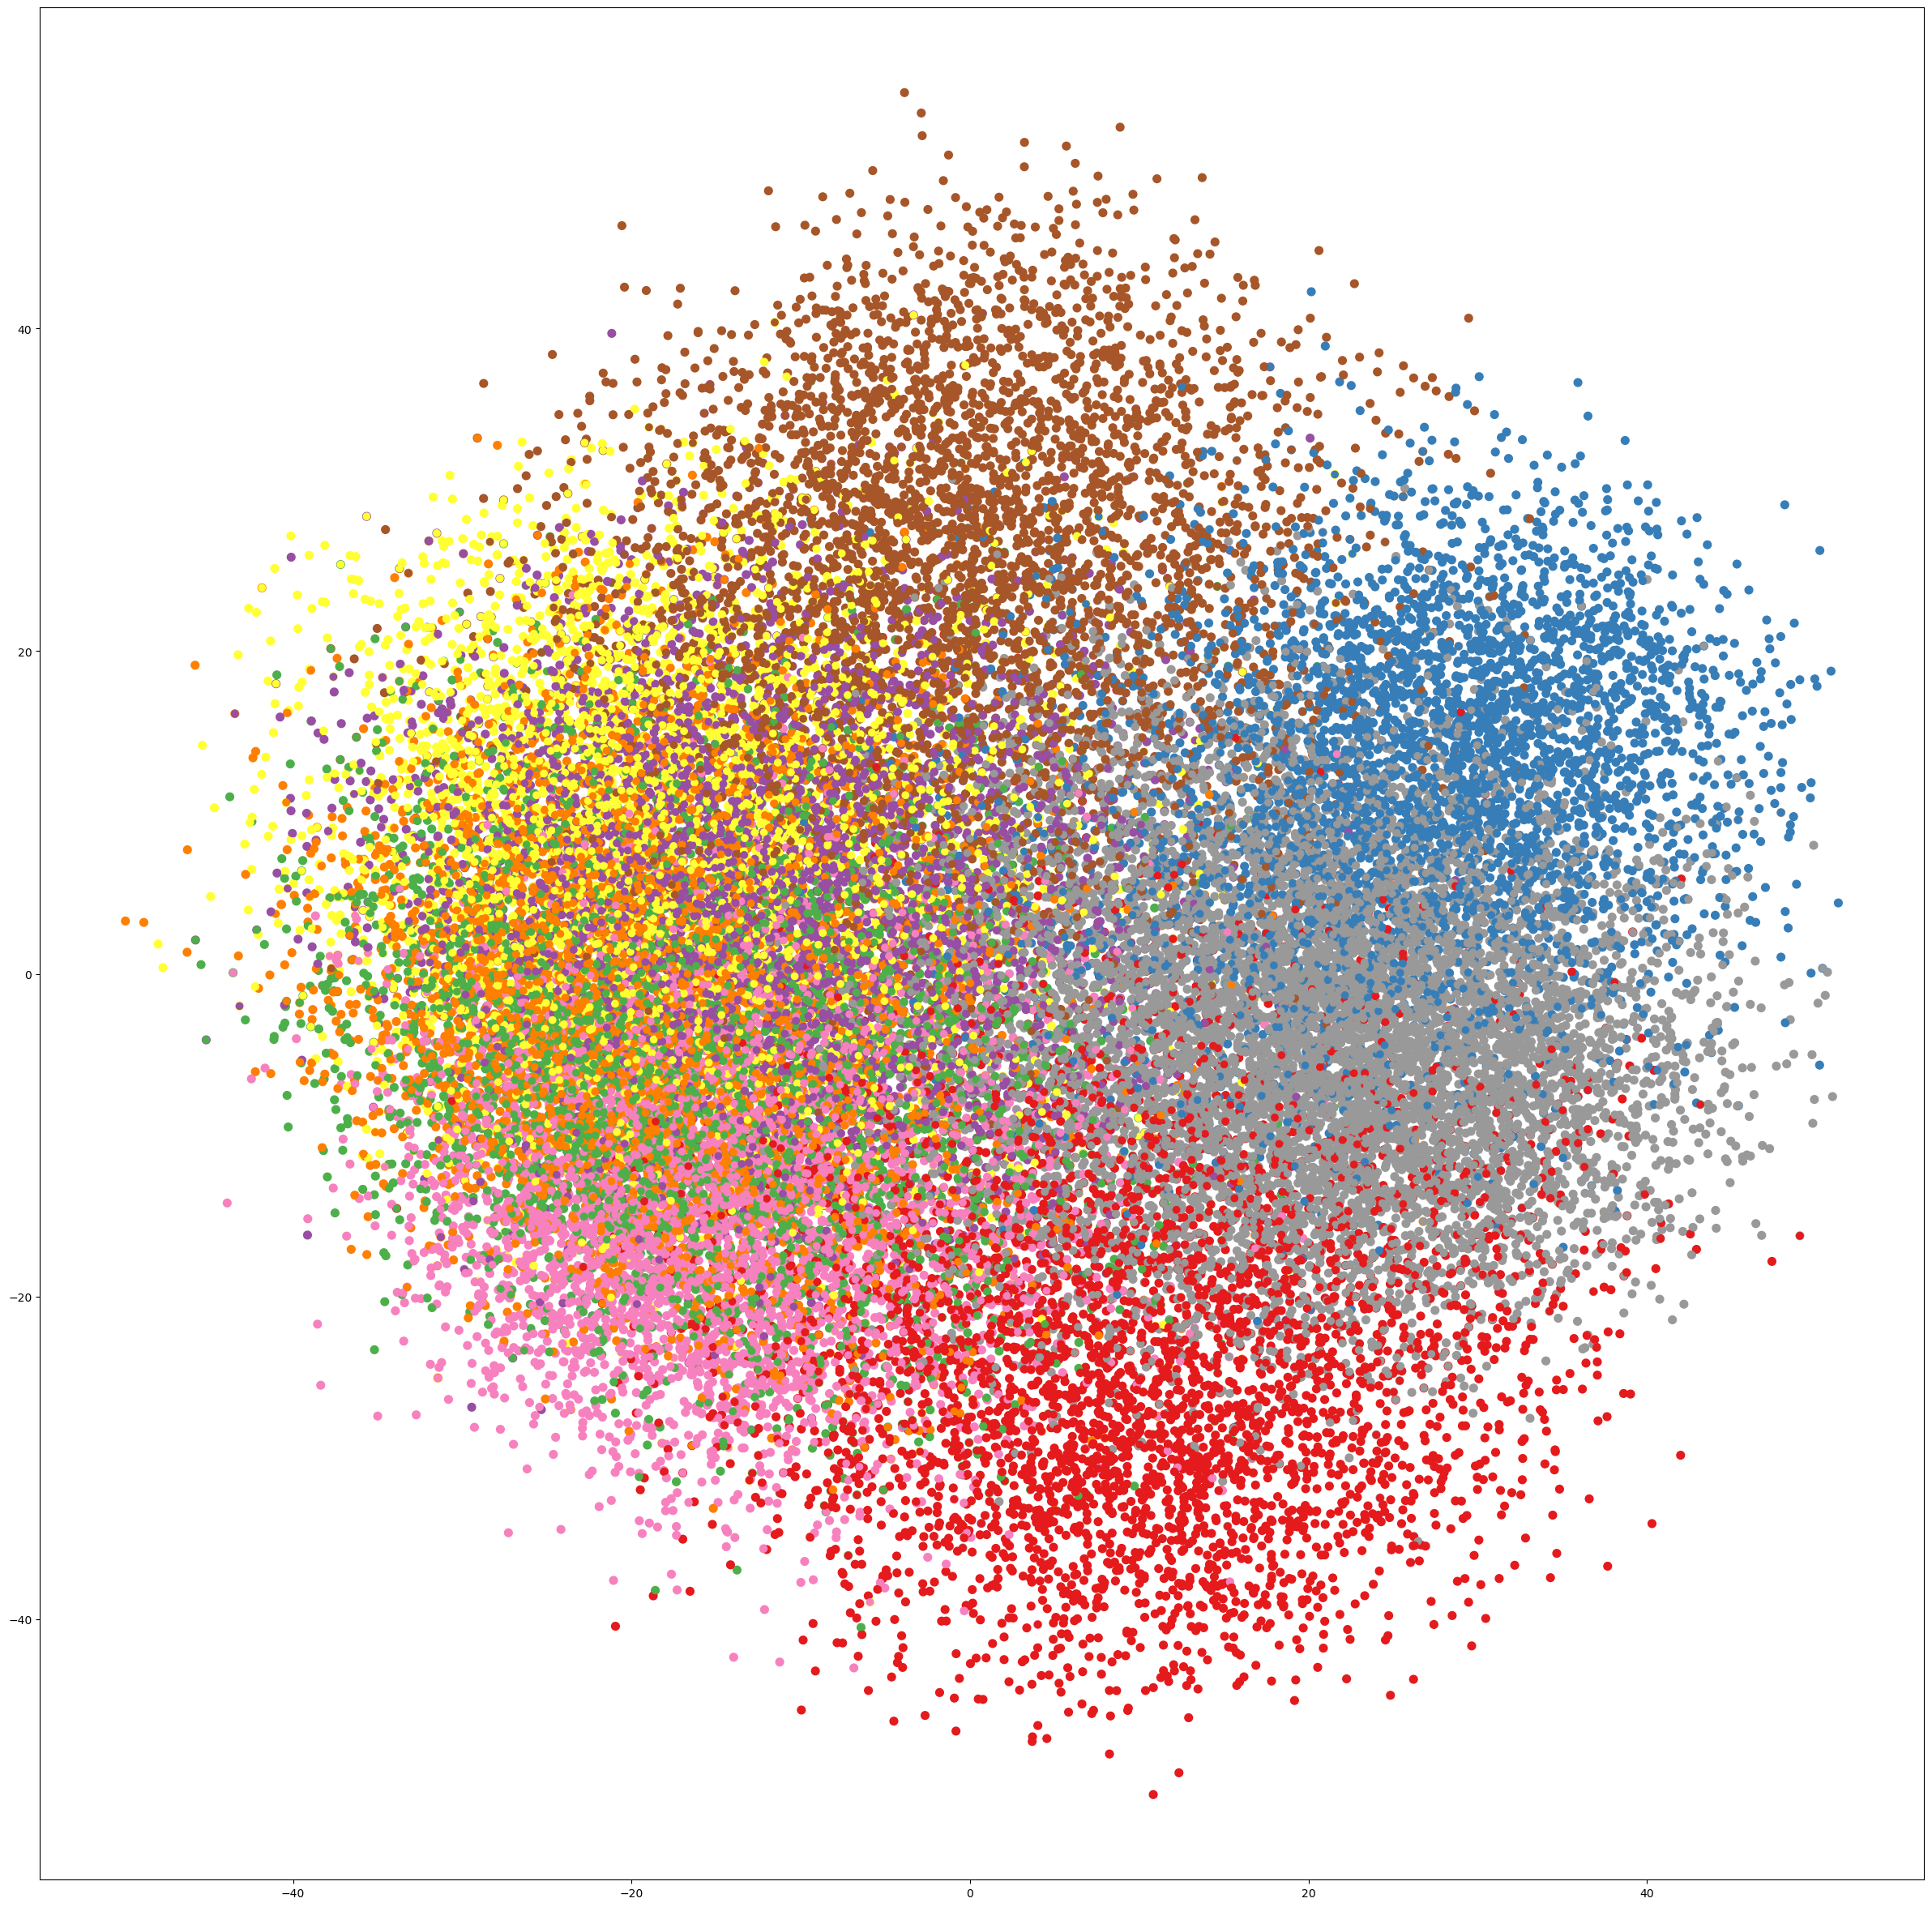

In [19]:
cmap = plt.get_cmap("Set1")
colors = cmap(cnn_descriptors_train_label)
plt.figure(figsize=(30,30))
plt.scatter(features_pca_cnn[:,0], features_pca_cnn[:,1], edgecolors=colors, facecolors='none', linewidths=2)
plt.scatter(features_pca_cnn[:,0], features_pca_cnn[:,1], c=cnn_descriptors_prediction, cmap=cmap)

**b)** Repeat the steps mentioned before but now on the test CNN descriptor set.

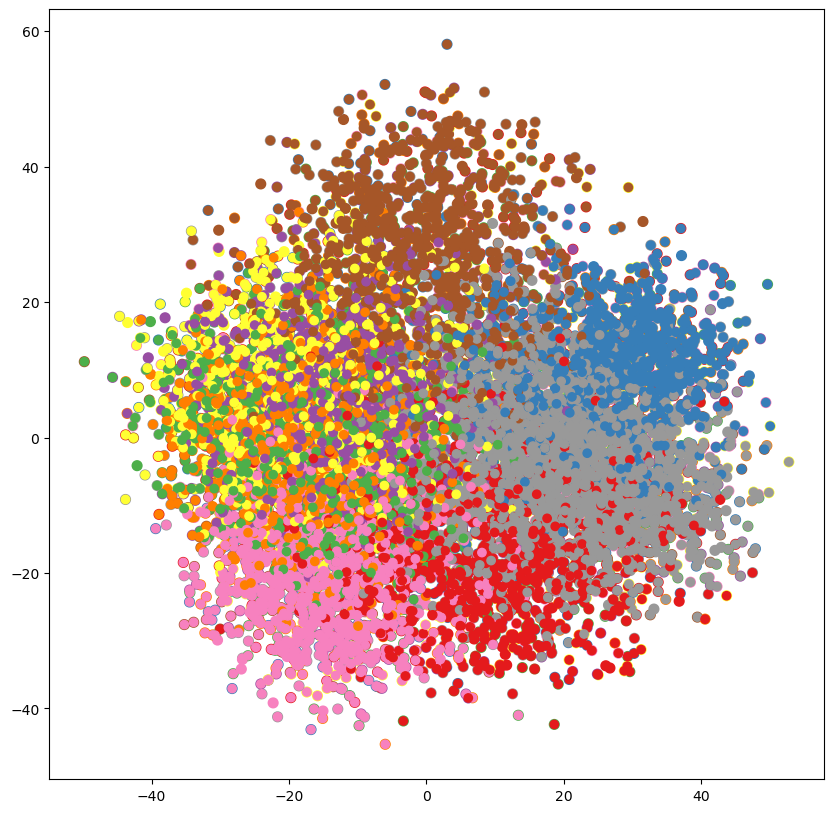

In [18]:
# Ex.2.6b your code here
cnn_descriptors_prediction_test = cnn_k_neighbors.predict(cnn_descriptors_test)
pca_test = PCA(n_components=2)
features_pca_cnn_test = pca.fit_transform(cnn_descriptors_test, cnn_descriptors_test_label)

plt.figure(figsize=(10,10))
plt.scatter(features_pca_cnn_test[:,0], features_pca_cnn_test[:,1], edgecolors=colors, facecolors='none',linewidths=2)
plt.scatter(features_pca_cnn_test[:,0], features_pca_cnn_test[:,1], c=cnn_descriptors_prediction_test, cmap='Set1')


#### Exercise 2.7 - kNN with k-Fold cross-validation

Assess the performance of your implemented kNN using k-Fold cross-validation. 

Run your implemented function evaluating for k (fold) = 2, 5 and 10. You can rely on the kNN that performed best in the previous exercises.
Report the average accuracy and the standard deviation.

In [38]:
# Load packages
from sklearn.model_selection import KFold
from sklearn.utils import shuffle
k_list = [2, 5, 10]
avg_acc_list = []
cnn_descriptors = np.array(cnn_descriptors)
cnn_descriptors_label = np.array(cnn_descriptors_label)

for k in k_list:
    kf = KFold(n_splits=k)
    print(k)
    current_acc_list = []
    for train_index, test_index in kf.split(X=cnn_descriptors, y=cnn_descriptors_label):
        cnn_k_neighbors = KNeighborsClassifier(n_neighbors=15)
        # print(f"  Train: index={train_index}")
        # print(f"  Test:  index={test_index}")
        train_set = cnn_descriptors[train_index]
        train_label = cnn_descriptors_label[train_index]
        test_set =  cnn_descriptors[test_index]
        test_label = cnn_descriptors_label[test_index]

        cnn_k_neighbors.fit(train_set, train_label)

        current_acc_list.append(cnn_k_neighbors.score(test_set, test_label))
    avg_acc_list.append(current_acc_list)

# Ex.2.7 your code here

2
5
10


In [42]:
## SUGGESTION ON HOW TO PRESENT PERFORMANCE OF YOUR KFOLD CROSS VALIDATION ANALYSIS
print('RESULTS:')
for i,k in enumerate(k_list):
    print(k,'-fold cross validation:')
    print('Accuracies per fold: ', avg_acc_list[i])
    avg_acc = round(sum(avg_acc_list[i])/k,3)
    std_list= round(np.std(avg_acc_list[i]),3)
    print('Average accuracy: ', avg_acc,'+-', std_list)
    print('---------------')

RESULTS:
2 -fold cross validation:
Accuracies per fold:  [0.8574, 0.85748]
Average accuracy:  0.857 +- 0.0
---------------
5 -fold cross validation:
Accuracies per fold:  [0.8628, 0.8594, 0.8667, 0.856, 0.8596]
Average accuracy:  0.861 +- 0.004
---------------
10 -fold cross validation:
Accuracies per fold:  [0.86, 0.8654, 0.8588, 0.8576, 0.8688, 0.867, 0.8572, 0.855, 0.8678, 0.852]
Average accuracy:  0.861 +- 0.006
---------------


        ### [Optional] Exercise: further explore by:
- implement other classifiers such as SVM or Random Forest, 
- extract other descriptors from the images such as objects or other local features,
- implement the evaluation metrics: recall, precision and f-score.